In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [3]:
dataset = pd.read_csv("creditcard.csv")

In [4]:
#check for any null values
print("Any nulls in the dataset",dataset.isnull().values.any())
print('-------')
print("No. of unique labels",len(dataset['Class'].unique()))
print("Label values",dataset.Class.unique())

#0 is for normal credit card transcation
#1 is for fraudulent credit card transcation
print('-------')
print("Break down of Normal and Fraud Transcations")
print(pd.value_counts(dataset['Class'],sort=True))

Any nulls in the dataset False
-------
No. of unique labels 2
Label values [0 1]
-------
Break down of Normal and Fraud Transcations
0    284315
1       492
Name: Class, dtype: int64


Text(0, 0.5, 'Number of Observations')

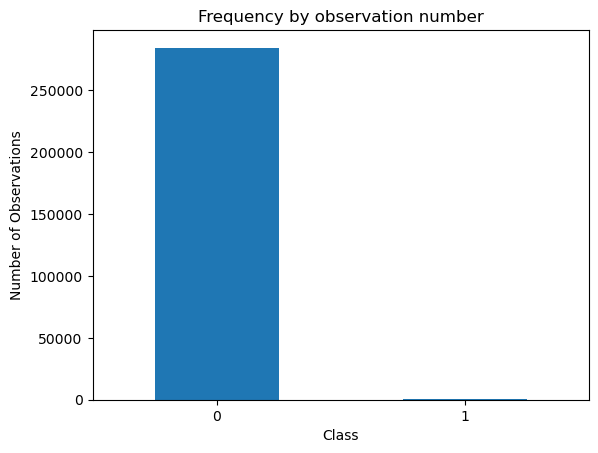

In [5]:
#visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.xticks(range(len(dataset['Class'].unique())),dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

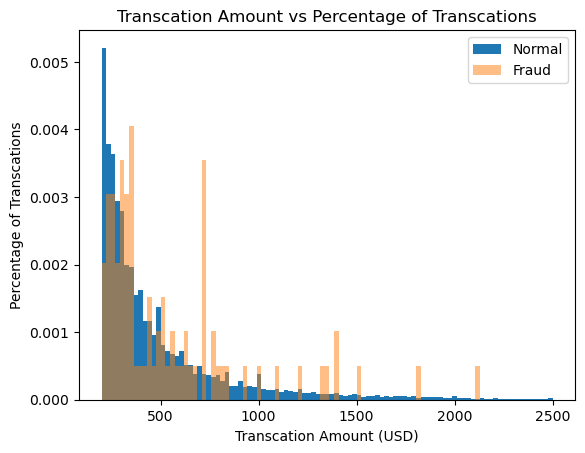

In [6]:
#Save the normal and fradulent transcations in seperate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

#Visualize transcation amounts for normal and fraudulent transcations
bins = np.linspace(200,2500,100)
plt.hist(normal_dataset.Amount,bins=bins,alpha=1,density=True,label='Normal')
plt.hist(fraud_dataset.Amount,bins=bins,alpha=0.5,density=True,label='Fraud')
plt.legend(loc='upper right')
plt.title("Transcation Amount vs Percentage of Transcations")
plt.xlabel("Transcation Amount (USD)")
plt.ylabel("Percentage of Transcations")
plt.show()

In [7]:
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1,1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1,1))

In [8]:
raw_data = dataset.values
#The last element contains if the transcation is normal which is represented by 0 and if fraud then 1
labels = raw_data[:,-1]

#The other data points are the electrocadriogram data
data = raw_data[:,0:-1]

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size = 0.2,random_state =2021)

In [9]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

In [10]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print("No. of records in Fraud Train Data=",len(fraud_train_data))
print("No. of records in Normal Train Data=",len(normal_train_data))
print("No. of records in Fraud Test Data=",len(fraud_test_data))
print("No. of records in Normal Test Data=",len(normal_test_data))

No. of records in Fraud Train Data= 389
No. of records in Normal Train Data= 227456
No. of records in Fraud Test Data= 103
No. of records in Normal Test Data= 56859


In [11]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
#num of columns,30
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7

In [12]:
#input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim,activation="tanh",activity_regularizer = tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2,activation=tf.nn.leaky_relu)(encoder)

#Decoder
decoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim,activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim,activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs = input_layer,outputs = decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [13]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.keras",mode='min',monitor='val_loss',verbose=2,save_best_only=True)
#Define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001,
                patience=10,
                verbose=11,
                mode='min',
                restore_best_weights=True
)

In [14]:
autoencoder.compile(metrics=['accuracy'],loss= 'mean_squared_error',optimizer='adam')

In [15]:
# history = autoencoder.fit(normal_train_data,normal_train_data,epochs = nb_epoch,
#                          batch_size = batch_size,shuffle = True,
#                          validation_data = (test_data,test_data),
#                          verbose=1,
#                          callbacks = [cp,early_stop]).history

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the ModelCheckpoint callback without unsupported arguments
cp = ModelCheckpoint(filepath='autoencoder_fraud.h5',  # Using .h5 format for compatibility
                     monitor='val_loss', 
                     save_best_only=True, 
                     verbose=1, 
                     save_format='h5')

# Define EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the autoencoder model
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_data, test_data),
                          verbose=1,
                          callbacks=[cp, early_stop]).history

Epoch 1/50
3541/3554 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.0535
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 7s 2ms/step - loss: 0.0042 - accuracy: 0.0534 - val_loss: 1.9851e-05 - val_accuracy: 0.0343
Epoch 2/50
  75/3554 [..............................] - ETA: 4s - loss: 1.8874e-05 - accuracy: 0.0827   

C:\Users\admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3534/3554 [============================>.] - ETA: 0s - loss: 1.9283e-05 - accuracy: 0.0684
Epoch 2: val_loss did not improve from 0.00002
3554/3554 [==============================] - 6s 2ms/step - loss: 1.9273e-05 - accuracy: 0.0682 - val_loss: 1.9949e-05 - val_accuracy: 0.0051
Epoch 3/50
3550/3554 [============================>.] - ETA: 0s - loss: 1.9442e-05 - accuracy: 0.0623
Epoch 3: val_loss did not improve from 0.00002
3554/3554 [==============================] - 6s 2ms/step - loss: 1.9442e-05 - accuracy: 0.0622 - val_loss: 2.0233e-05 - val_accuracy: 0.0010
Epoch 4/50
3547/3554 [============================>.] - ETA: 0s - loss: 1.9556e-05 - accuracy: 0.0640
Epoch 4: val_loss did not improve from 0.00002
3554/3554 [==============================] - 5s 2ms/step - loss: 1.9554e-05 - accuracy: 0.0641 - val_loss: 2.0233e-05 - val_accuracy: 0.0343
Epoch 5/50
3553/3554 [============================>.] - ETA: 0s - loss: 1.9551e-05 - accuracy: 0.0581
Epoch 5: val_loss did not improve from 

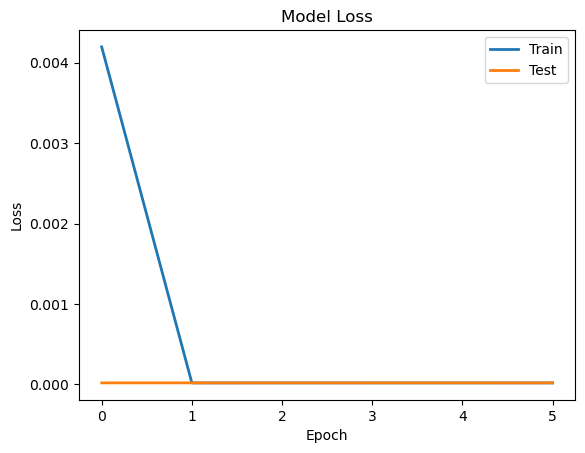

In [16]:
plt.plot(history['loss'],linewidth = 2,label = 'Train')
plt.plot(history['val_loss'],linewidth = 2,label = 'Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [17]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2),axis = 1)
error_df = pd.DataFrame({'Reconstruction_error':mse,
                         'True_class':test_labels})

1781/1781 [==============================] - 2s 847us/step


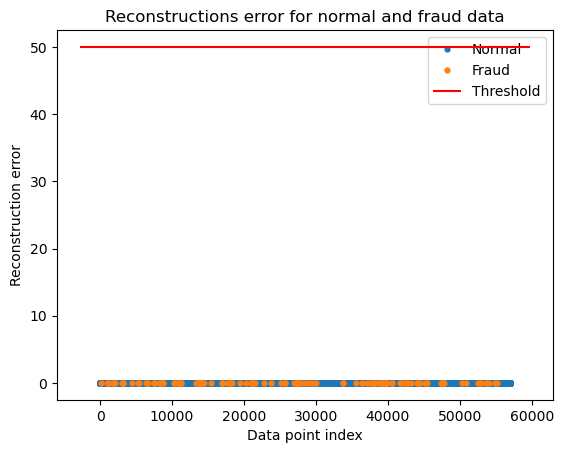

In [18]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig,ax = plt.subplots()

for name,group in groups:
        ax.plot(group.index,group.Reconstruction_error,marker='o',ms = 3.5,linestyle='',
                label = "Fraud" if  name==1 else "Normal")
ax.hlines(threshold_fixed,ax.get_xlim()[0],ax.get_xlim()[1],colors="r",zorder=100,label="Threshold")
ax.legend()
plt.title("Reconstructions error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

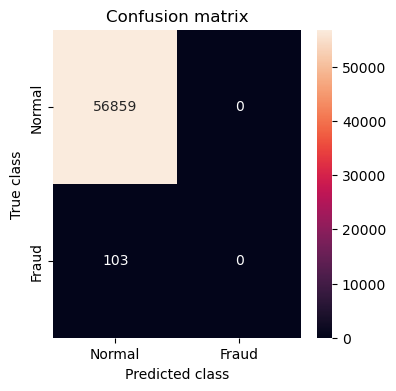

Accuracy : 0.9981917769741231
Recall : 0.0
Precision : 0.0


C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0 
          for e in 
        error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class,pred_y)

plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix,xticklabels = LABELS,yticklabels = LABELS,annot = True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

#Print Accuracy,Precision and Recall
print("Accuracy :",accuracy_score(error_df['True_class'],error_df['pred']))
print("Recall :",recall_score(error_df['True_class'],error_df['pred']))
print("Precision :",precision_score(error_df['True_class'],error_df['pred']))